# <center>**ML School by REU Data Scinece Club**</center>

---
## <center> Неделя №3 </center>




На этой неделе вам предстоит обработать данные о зарплатах. Данные очень похожи на настоящие, поэтому вам будет в каких-то моментах неприятно) В них очень много мусора и поэтому понадобиться потратить время на обработку. DS - специалист работает с чем-то подобным крайне часто.
Если столкнетесь с проблемой, пишите в чат, где вам помогут авторы и остальные участники, решать проблемы в коллективе - легче. Удачи!

Про данные можно прочитать [тут](https://oscarbaruffa.com/messy/)

Импортируем библиотеки которые могут вам понадобиться, а затем загрузим данные

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
!pip install forex-python
from forex_python.converter import CurrencyRates
!pip install easy-exchange-rates
from easy_exchange_rates import API
from sklearn.impute import SimpleImputer


Теперь давайте скачаем нужные данные


In [ ]:
!git clone https://github.com/MeinRespect/REU-Ml-SCHOOL.git

fatal: destination path 'REU-Ml-SCHOOL' already exists and is not an empty directory.


In [ ]:
df = pd.read_csv('/content/REU-Ml-SCHOOL/right_data.csv', parse_dates=['Timestamp'])
df.columns = ['Timestamp', 'Age','Industry', 'Job', 'Job_context', 'Salary',
              'Amount_of_monetary_compensation', 'Currency',
              'Currency_special', 'Income_context', 'Country',
              'State_in_USA', 'City', 'Work_expirince_all',
              'Work_expirince_in_current_field', 'Education', 'Gender', 'Race'
              ]
df.head()

,Timestamp,Age,Industry,Job,Job_context,Salary,Amount_of_monetary_compensation,Currency,Currency_special,Income_context,Country,State_in_USA,City,Work_expirince_all,Work_expirince_in_current_field,Education,Gender,Race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,"55,000",0.0,USD,NaN,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,"54,600",4000.0,GBP,NaN,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,NaN,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,"34,000",NaN,USD,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,"62,000",3000.0,USD,NaN,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,"60,000",7000.0,USD,NaN,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White


# **Задание 1. Чистка данных (6 баллов)**

In [ ]:
df.shape

(27945, 18)

## Этап 1.1
Теперь вам нужно привести колонки Salary и Amount of monetary compensation к единой шкале измерения - доллару.
Для этого вы можете использовать два способа:

1.   Простой. Вы берете сегодняшнюю дату и приводите все основные валюты из колонки Currency к доллару, а те строчки, где значение колонки равно "Other", вы удаляете.
2.   Сложный. Вы смотрите на значение Timestamp и актуальный для этой даты курс. Если в Currency встречается значение "Other", то вы пытаетесь восстановить валюту по колонке Currency Special. Тут вам может пригодится библиотека [forex](https://forex-python.readthedocs.io/en/latest/usage.html). Внимание! Библиотека часто не работает и выдает различные ошибки. Вы можете попробовать найти альтернативу или придмать свой интересный способ.

За оба решения вы получите **одинаковое количество баллов**, но учитывайте, что в простом вы теряете много полезной информации.

In [ ]:
# Очищаем датафрейм от других валют (Other) и шумов, а также приводим колонку с зарплатой к типу int
df['Currency_special'] = df['Currency_special'].fillna(0)
df = df.query('Currency != "Other"').query('Currency_special == 0')
df['Currency'] = df['Currency'].apply(lambda x: 'AUD' if x == 'AUD/NZD' else x)
df['Salary'] = df['Salary'].apply(lambda x: x.replace(',', '')).astype(int)

In [ ]:
# Получаем датафрейм rates с курсами за необходимый период, изпользуя
api = API()
time_series = api.get_exchange_rates(
  base_currency="USD",
  start_date="2021-04-27",
  end_date="2022-04-27",
  targets=list(df['Currency'].value_counts().index)
)
exchange_rates_1 = api.to_dataframe(time_series)

time_series = api.get_exchange_rates(
  base_currency="USD",
  start_date="2022-04-28",
  end_date="2023-03-09",
  targets=list(df['Currency'].value_counts().index)
)
exchange_rates_2 = api.to_dataframe(time_series)

rates = pd.concat([exchange_rates_1, exchange_rates_2])

In [ ]:
# Преобразуем зарплаты и премии к единой валюте (USD)
def get_rate(x, y):
  return rates.loc[x, y]
df['only_date'] = df['Timestamp'].apply(lambda x: x.date()).astype(str)
df['Salary'] = (df['Salary'] / df.apply(lambda x: get_rate(x.only_date, x.Currency), axis=1)).round(2)

df['Amount_of_monetary_compensation'] = (df['Amount_of_monetary_compensation'] / df.apply(lambda x: get_rate(x.only_date, x.Currency), axis=1)).round(2)

In [ ]:
# Удалим лишние столбцы за ненадобностью
df = df.drop(['Currency', 'Currency_special', 'only_date'], axis=1)
df

,Timestamp,Age,Industry,Job,Job_context,Salary,Amount_of_monetary_compensation,Income_context,Country,State_in_USA,City,Work_expirince_all,Work_expirince_in_current_field,Education,Gender,Race
0,2021-04-27 11:02:10,25-34,Education (Higher Education),Research and Instruction Librarian,NaN,55000.00,0.00,NaN,United States,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
1,2021-04-27 11:02:22,25-34,Computing or Tech,Change & Internal Communications Manager,NaN,75913.36,5561.42,NaN,United Kingdom,NaN,Cambridge,8 - 10 years,5-7 years,College degree,NaN,White
2,2021-04-27 11:02:38,25-34,"Accounting, Banking & Finance",Marketing Specialist,NaN,34000.00,NaN,NaN,US,Tennessee,Chattanooga,2 - 4 years,2 - 4 years,College degree,Woman,White
3,2021-04-27 11:02:41,25-34,Nonprofits,Program Manager,NaN,62000.00,3000.00,NaN,USA,Wisconsin,Milwaukee,8 - 10 years,5-7 years,College degree,Woman,White
4,2021-04-27 11:02:42,25-34,"Accounting, Banking & Finance",Accounting Manager,NaN,60000.00,7000.00,NaN,US,South Carolina,Greenville,8 - 10 years,5-7 years,College degree,Woman,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27940,2023-02-23 15:45:08,25-34,"Accounting, Banking & Finance",Associate Business Development,NaN,46160.22,7388.59,NaN,Canada,NaN,Toronto,8 - 10 years,2 - 4 years,College degree,Woman,White
27941,2023-02-27 06:22:35,25-34,Computing or Tech,Sr software engineer,NaN,190000.00,14000.00,NaN,United States,Texas,Dallas,5-7 years,5-7 years,College degree,Man,Asian or Asian American
27942,2023-03-01 09:43:37,45-54,Property or Construction,Property Manager,Senior,55000.00,13000.00,NaN,United States,Ohio,Brunswick,21 - 30 years,11 - 20 years,NaN,NaN,NaN
27943,2023-03-06 18:16:19,25-34,Behavioral Health,Mental Health Therapist,NaN,52416.00,NaN,NaN,USA,Virginia,Spotsylvania,2 - 4 years,2 - 4 years,Master's degree,Woman,White


## Этап 1.2
Приведите страны к единым названиям, например в данных не должно быть одновременно USA и United States. Различных значений много, но постарайтесь сохранить как можно больше информации. Строки с нерелевантными значениями удалите. В качестве помощи мы уже подготовили значения для замены некоторых стран. Обрабатывать все наблюдения необязательно, но постарайтесь восстановить как можно больше значений.                                   

In [ ]:
usa_names = ['United States', 'US', 'USA',
       'usa', 'U.S.', 'United States ', 'us',
       'Usa', 'United States of America', 'United states', 'USA ',
       'United states ','united states', 'United States of America ',
       'U.S. ', 'U.S>', 'ISA', 'US ', 'United State', 'U.S.A',
       'U.S.A.', 'America', 'united states of america', 'Us', 'The United States',
       'United State of America', 'United Stated','u.s.', 'UNITED STATES', 'united States',
       'USA-- Virgin Islands', 'U.S', 'Unites States ', 'Usa ', 'U.S.A. ',
       'U. S. ', 'United Sates', 'United States of American ''Uniited States',
       'Worldwide (based in US but short term trips aroudn the world)',
       'United Sates of America', 'United States', 'america', 'Unted States', 'United Statesp',
       'United Stattes', 'United Statea', 'Unites States', 'United Statees',
       'UNited States', 'Uniyed states', 'Uniyes States', 'United States of Americas',
       'U.A.', 'U. S.' 'US of A', 'United States of america ',
       'U.SA', 'United Status', ' U.S.', 'Serbia', 'Canada and USA',
       'Virginia', 'U.s.', 'U.s.a.', 'USS', 'Uniteed States', 'United Stares',
       ' US', 'Unites states ', 'Us ', 'Unite States', 'The US',
       'united states ', 'United States (I work from home and my clients are all over the US/Canada/PR',
       'United states of America ', 'For the United States government, but posted overseas',
       'From Romania, but for an US based company', 'UnitedStates', 'Uniited States',
       'United States of america', 'United statew', ' United States', 'United Statues',
       'Untied States', 'United States of American ', 'USA (company is based in a US territory, I work remote)',
       'USAB', 'Unitied States', 'United Sttes', 'united stated', 'United States Of America',
       'Uniter Statez', 'U. S ', 'United states of America',
       'USA tomorrow ', 'United Stateds', 'Japan, US Gov position',
       'n/a (remote from wherever I want)',  'US govt employee overseas, country withheld', 'usa ',
       'San Francisco', 'Usat', '🇺🇸 ', 'Unitef Stated', 'UA',
       'United Stares ', 'United STates', 'USaa', 'uSA',
       'United States- Puerto Rico','California ', 'US of A',
       'uS', 'USD', "USA, but for foreign gov't", 'U. S.', 'United y',
       'United Statss', 'United states of america', 'UsA',
       'I work for a UAE-based organization, though I am personally in the US.',
       'United  States',  'United States is America',
       'United States of American', 'U.S.A ', 'United Statws', 'U. S', 'California',
       'I am located in Canada but I work for a company in the US', '🇺🇸', 'Unites states']

uk_names = ['United Kingdom', 'United Kingdom ', 'Scotland ',
           'United Kingdom', 'UK ', 'England/UK',
           'UK', 'Great Britain ', 'Englang',
           'Scotland', 'UK (England)',
           'England', 'UK', 'Wales (United Kingdom)', 'England ',
           'Ireland', 'United kingdom ', 'Uk', 'united kingdom',
           'Great Britain', 'UK for U.S. company',
           'England', 'U.K. (northern England)', 'U.K',
           'Ireland', 'Wales (UK)', 'ireland'
           'Northern Ireland',  'europe', 'United Kingdom (England)',
           'United Kingdom.', 'Northern Ireland ', 'england',
           'United kingdom', 'United Kingdomk', 'UK (Northern Ireland)',
           'England, Gb', 'UK, remote', 'ENGLAND', 'England, UK.',
           'England, United Kingdom', 'U.K.', 'Scotland, UK', 'Wales', 'United Kindom',
           'Wales, UK', 'Unites kingdom',  'U.K. ',
           'Wales, UK', 'England, UK',  'Uk ',  'uk',
           'Northern Ireland, United Kingdom', 'uk',
           'UK, but for globally fully remote company', 'Northern Ireland', 'Britain']

canada_names = ['canada', 'Canada ', 'Canada, Ottawa, ontario', 'CANADA ',
               'Canadw', 'CANADA', 'Can', 'Canda', 'Canad', 'Csnada', 'Canadá', 'Canada ', 'Canad', 'Csnada', 'Canada']

ger_names = ['Germany ', 'germany', 'Company in Germany. I work from Pakistan.', 'Germany']



australia_names = ['australia', 'australi']
new_zealand_names = ['nz', 'new zealand']
france_names = ['france']
netherlands_names = ['the netherlands', 'netherlands', 'nederland']
spain_names = ['spain']
sweden_names = ['sweden']
switzerland_names = ['switzerland']
belgium_names = ['belgium']
japan_names = ['japan']
austria_names = ['austria']
finland_names = ['finland']
south_africa_names = ['south africa']
italy_names = ['italy']
denmark_names = ['danmark', 'denmark']

In [ ]:
# Пишем функцию, которая обработает большинство значений. Если у страны больше 10 упоминаний, мы обрабатываем её. Иначе даём ей значение Other.
def correction_names(name):
  if name in usa_names:
    name = 'USA'
  elif name in uk_names:
    name = 'UK'
  elif name in canada_names:
    name = 'Canada'
  elif name in ger_names:
    name = 'Germany'
  elif name.lower() in australia_names:
    name = 'Australia'
  elif name.lower() in new_zealand_names:
    name = 'New Zealand'
  elif name.lower() in france_names:
    name = 'France'
  elif name.lower() in netherlands_names:
    name = 'Netherlands'
  elif name.lower() in spain_names:
    name = 'Spain'
  elif name.lower() in sweden_names:
    name = 'Sweden'
  elif name.lower() in switzerland_names:
    name = 'Switzerland'
  elif name.lower() in belgium_names:
    name = 'Belgium'
  elif name.lower() in japan_names:
    name = 'Japan'
  elif name.lower() in austria_names:
    name = 'Austria'
  elif name.lower() in finland_names:
    name = 'Finland'
  elif name.lower() in south_africa_names:
    name = 'South Africa'
  elif name.lower() in italy_names:
    name = 'Italy'
  elif name.lower() in denmark_names:
    name = 'Denmark'
  else:
    name = 'Others'
  return name

df['Country'] = df['Country'].apply(correction_names)

In [ ]:
df['Country'].value_counts()

USA             23083
UK               1687
Canada           1675
Australia         311
Others            309
Germany           194
New Zealand       103
Netherlands        76
France             66
Spain              45
Sweden             34
Belgium            33
Switzerland        30
Japan              27
Austria            17
Finland            16
Italy              14
South Africa       13
Denmark            11
Name: Country, dtype: int64

# **Задание 2. Замена пропущенных значений (5 баллов)**



## Этап 2.1
Найдите в данных пропущенные значения и выведите их количество для каждой колонки:

In [ ]:
# Ваш код тут
df.isna().sum()

Timestamp                              0
Age                                    0
Industry                              71
Job                                    0
Job_context                        20571
Salary                                 0
Amount_of_monetary_compensation     7195
Income_context                     24750
Country                                0
State_in_USA                        4818
City                                  75
Work_expirince_all                     0
Work_expirince_in_current_field        0
Education                            210
Gender                              1192
Race                                 166
dtype: int64

Замените пропущенные значения во всех колонках **кроме Education**. Там где можно сделайте это с помощью моды, а в колонках по типу State in USA замените на определенное значение, в данном случае Another Country, а в Amount of monetary compensation на 0

In [ ]:
df['Industry'] = df['Industry'].fillna(df['Industry'].mode()[0])
df['Job_context'] = df['Job_context'].fillna('Unknown')
df['Amount_of_monetary_compensation'] = df['Amount_of_monetary_compensation'].fillna(0)
df['Income_context'] = df['Income_context'].fillna('N/A')
df['State_in_USA'] = df['State_in_USA'].fillna('Another Country')
df['City'] = df['City'].fillna(df['City'].mode()[0])
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Race'] = df['Race'].fillna(df['Race'].mode()[0])

In [ ]:
df.isna().sum()

Timestamp                            0
Age                                  0
Industry                             0
Job                                  0
Job_context                          0
Salary                               0
Amount_of_monetary_compensation      0
Income_context                       0
Country                              0
State_in_USA                         0
City                                 0
Work_expirince_all                   0
Work_expirince_in_current_field      0
Education                          210
Gender                               0
Race                                 0
dtype: int64

## Этап 2.2
Давайте теперь попоробуем заменить пропущенные значения при помощи Sklearn. В этой библиотеке есть много классных методов для замены пропусков и они позволяют это делать более точнее. В данном случае мы возьмем самый простой - [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

Что нужно сделать:

1.   Импортируйте библиотеку
2.   Замените пропуски в колонке Education с помощью SimpleImputer(пример есть в документации, также лучше использовать параметр strategy=most_frequent).
3.   Преобразуйте результат из numpy.array в датафрейм и поменяйте название колонок
4.   Замените старый датасет на новый


In [ ]:
df['Education'].value_counts()

College degree                        13369
Master's degree                        8787
Some college                           2031
PhD                                    1415
Professional degree (MD, JD, etc.)     1312
High School                             620
Name: Education, dtype: int64

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df['Education'] = imp_mean.fit_transform(df['Education'].values.reshape(-1,1))

In [ ]:
df['Education'].value_counts()

College degree                        13579
Master's degree                        8787
Some college                           2031
PhD                                    1415
Professional degree (MD, JD, etc.)     1312
High School                             620
Name: Education, dtype: int64

In [ ]:
df.isna().sum()

Timestamp                          0
Age                                0
Industry                           0
Job                                0
Job_context                        0
Salary                             0
Amount_of_monetary_compensation    0
Income_context                     0
Country                            0
State_in_USA                       0
City                               0
Work_expirince_all                 0
Work_expirince_in_current_field    0
Education                          0
Gender                             0
Race                               0
dtype: int64

# **Задание 3. Построение графиков (5 баллов)**


Давайте начинать исследование наших данных с помошью графиков. Для начала оцените по графику violin plot как распределна зарплата и есть ли в ней выбросы. Если у вас не получается построить нормальный график, то вам нужно удалить аномально большие значения.

---

**Важно! Графики должны быть читаемыми**

<Axes: >

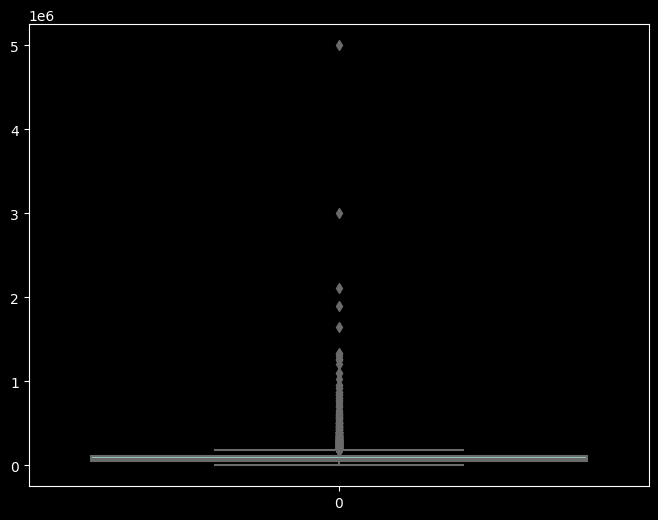

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(df['Salary'])

**Посмотрим на выбросы, используя box plot. Совсем аномальными являются значения на уровне около 300 и 500 тысяч. Попробуем построить violin plot без них.**

<Axes: >

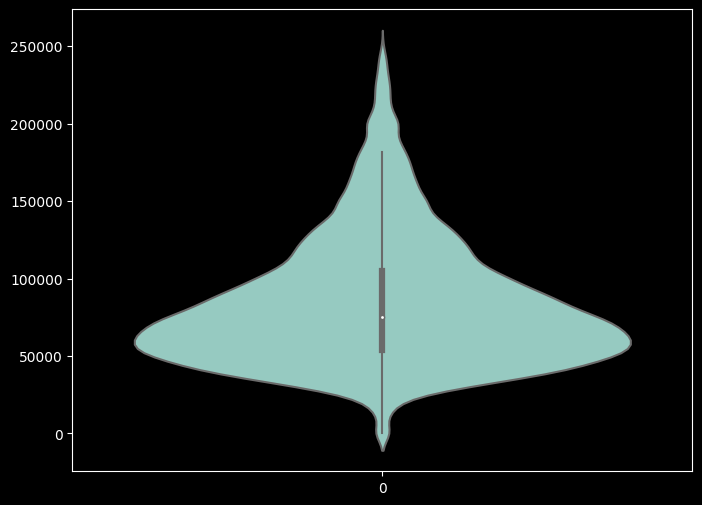

In [ ]:
# Ваш код тут
plt.figure(figsize=(8, 6))
sns.violinplot(df['Salary'][df['Salary'] < 250000])

Теперь давайте ответим на несколько вопросов о наших данных с помощью графиков

**1)** У каких десяти индустрий самые высокие средние зарплаты? (Для этого лучше всего подойдет barplot)

In [ ]:
# Ваш код тут
dt = df.groupby('Industry')['Salary'].mean().sort_values(ascending=False)[:10].reset_index()
dt.loc[4, 'Industry'] = 'Energy (oil & gas)'
dt.loc[0, 'Industry'] = 'Comm. Building Material Dist.'
dt

,Industry,Salary
0,Comm. Building Material Dist.,400000.00
1,Sports,300000.00
2,Corporate Training,280000.00
3,Customer service,275846.35
4,Energy (oil & gas),253300.00
5,Multilateral Organisation,250000.00
6,Pharmaceutical/biotechnology,227500.00
7,Biotech/pharmaceuticals,222000.00
8,Big Pharma,220000.00
9,Petroleum,220000.00


<Axes: xlabel='Industry', ylabel='Salary'>

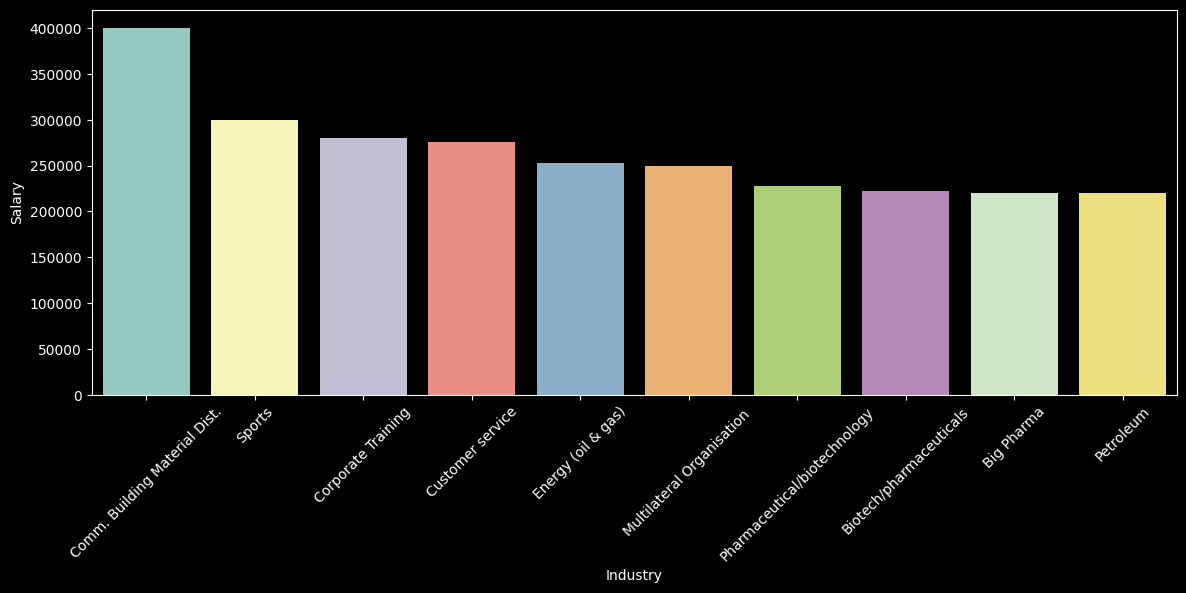

In [ ]:
plt.figure(figsize=(14, 5))
plt.xticks(rotation=45)
sns.barplot(y = dt['Salary'], x=dt['Industry'])

In [ ]:
df[df['Industry'] == 'Commercial Building Material Distribution']

,Timestamp,Age,Industry,Job,Job_context,Salary,Amount_of_monetary_compensation,Income_context,Country,State_in_USA,City,Work_expirince_all,Work_expirince_in_current_field,Education,Gender,Race
8753,2021-04-27 16:37:01,55-64,Commercial Building Material Distribution,Senior Vice President,Unknown,400000.0,150000.0,"Bonus varies from $100,000 to $250,000",USA,New York,New York City,21 - 30 years,21 - 30 years,Some college,Man,White


**С серьёзным отрывом от конкурентов лидирует сфера продаж строительных материалов, но это не существенно, поскольку связано с тем, что в наших данных всего один сотрудник из этой индустрии.**

**2)** Влияет ли опыт работы на среднюю зарплату? (Для этого лучше всего подойдет barplot)

In [ ]:
da = df.groupby('Work_expirince_in_current_field', as_index=False)['Salary'].mean()
da.loc[6, 'Work_expirince_in_current_field'] = '5 - 7 years'
da['sort'] = da['Work_expirince_in_current_field'].apply(lambda x: int(x.split()[0]))
da = da.sort_values(by='sort')
da

,Work_expirince_in_current_field,Salary,sort
0,1 year or less,60795.867151,1
2,2 - 4 years,70171.795680,2
6,5 - 7 years,82712.438257,5
7,8 - 10 years,92938.565993,8
1,11 - 20 years,103851.497236,11
3,21 - 30 years,121390.264676,21
4,31 - 40 years,111139.937836,31
5,41 years or more,102050.310000,41


**Создадим сводную таблицу со средним значением з/п по каждой категории, которую отсортируем по опыту работы в текущей сфере.**

<Axes: xlabel='Work_expirince_in_current_field', ylabel='Salary'>

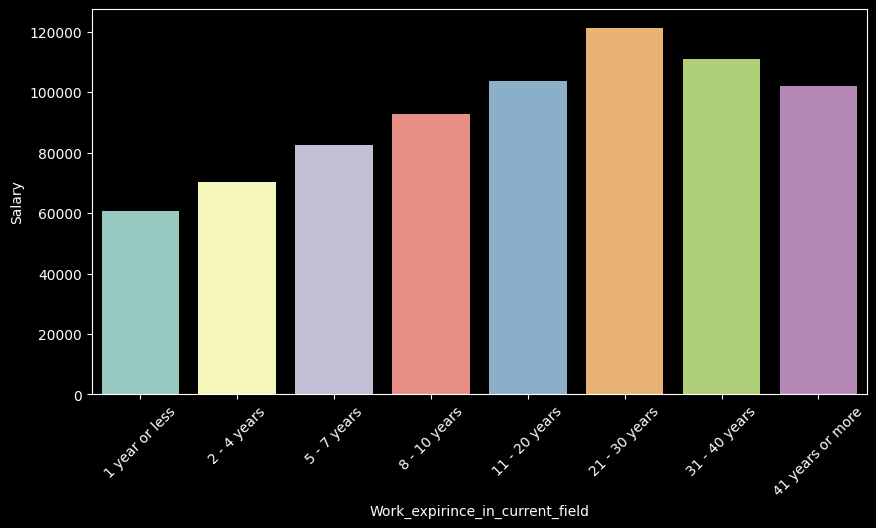

In [ ]:
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.barplot(y=da['Salary'], x=da['Work_expirince_in_current_field'])

**По графику можно сделать вывод о том, что опыт работы положительно коррелирует с средней зарплатой. Эта зависимость прослеживается вплоть до 30 лет опыта, далее следует обратная ситуация. Возможно, это связано со старением сотрудников.**

**3)** Выделяется ли в зарплате и премиях зависимость от образования? (Тут нужно выбрать значения Amount of monetary compensation неравные 0)

In [ ]:
de = (df[(df['Amount_of_monetary_compensation'] != 0) & (df['Salary'] < 250000)]
      .groupby('Education')[['Salary', 'Amount_of_monetary_compensation']]
      .agg(['mean', 'median']).reset_index())
de.columns = ['education', 'salary_mean', 'salary_median', 'amount_mean', 'amount_median']
de['education'] = pd.Categorical(de['education'], ['High School', 'Some college', 'College degree', 'Professional degree (MD, JD, etc.)', "Master's degree", "PhD"])
de.sort_values(by='education', inplace=True)
de

,education,salary_mean,salary_median,amount_mean,amount_median
1,High School,78676.564828,64750.000,20123.401241,5380.71
5,Some college,79145.968508,66433.110,16926.677920,5000.00
0,College degree,90996.017788,81473.030,16392.300403,6000.00
4,"Professional degree (MD, JD, etc.)",131742.127542,125617.500,22798.513051,10000.00
2,Master's degree,100464.150302,93000.000,16995.309051,7000.00
3,PhD,115178.445942,110491.495,19681.559983,10000.00


[Text(0.5, 1.0, 'Median salary for degrees')]

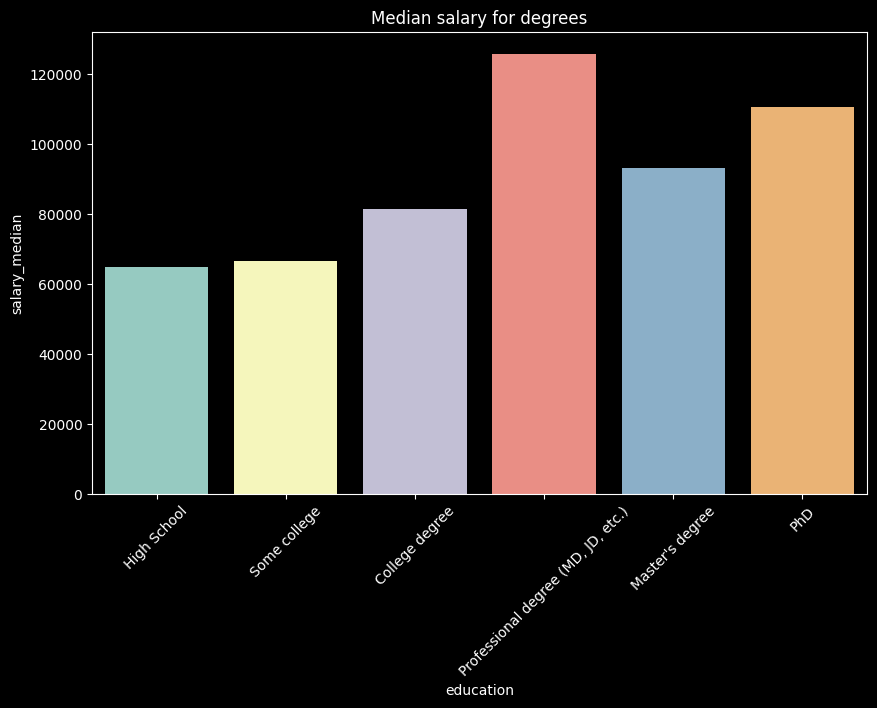

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.barplot(data=de, x='education', y='salary_median').set(title='Median salary for degrees')

[Text(0.5, 1.0, 'Median compensation for degrees')]

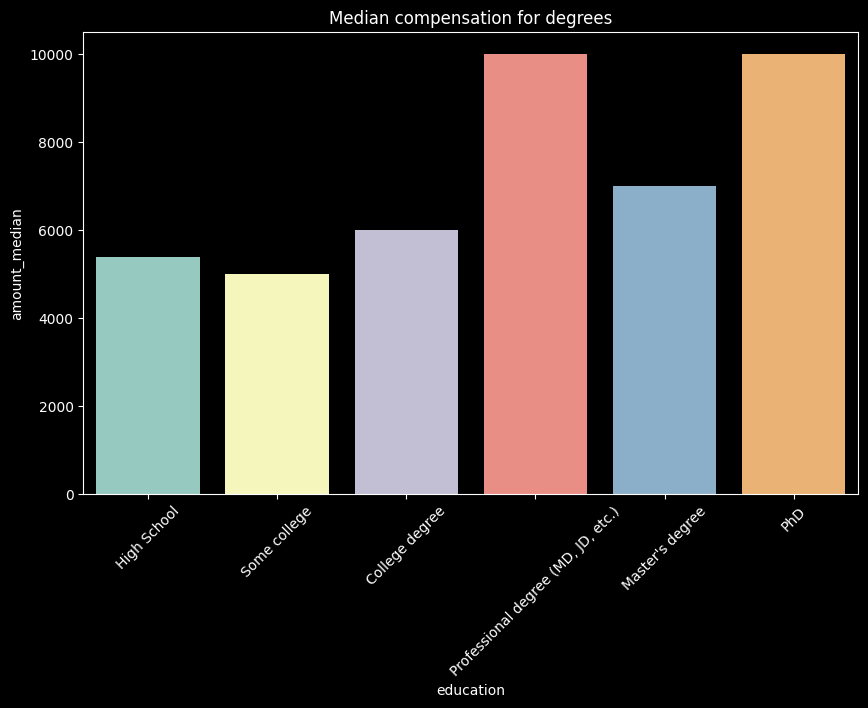

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=45)
sns.barplot(data=de, x='education', y='amount_median').set(title='Median compensation for degrees')

**Отсортируем в порядке возростания ученических степеней и построим столбчатую диаграмму по медианным значениям, чтобы получить более правильную картину.
В результате, люди с Professional degree получают сильно больше, чем другие. Возможно, это связано с тем, что на высокооплачиваемые должности берут только с ней. Просадка по Master's degree и PhD связана с тем, что эти степени преимущественно получают те, кто идут в науку. Говоря в общем, существует положительная зависимость з/п и премии от образования.**



# **Задание 4. Создание новых признаков (4 балла)**

Давайте теперь создадим **2 новых признака**. Мы предлагаем вам три идеи, но вы вправе придумать что то свое. Главное условие, признаки не должны повторять предыдущие и быть линейно зависимыми. например нельзя просто умножить колонку Salary на два и добавить ее к датафрейму.

Идеи которые предлагаем мы:

1.   Преобразовать колонку Race и сделать ее полезной для будующей модели. Это не совсем создание нового признака, скорее преобразование старого. Все расы в ней разделены союзом or или запятой. Вы можете создать аналог дамми переменных и разделить расы на колонки. если человек указал данную расу - ставить 1.
2.   Создать новую колонку с населением города, в котором живет человек. Для этого вы можете взять данные по пути - /content/REU-Ml-SCHOOL/city_population_data.csv.
3. Добавить колонку со cредней зарплатой человека, основанной на его возрасте и опыте работы.


**Первый признак: преобразуем расу в дамми-переменную, обязательно убрав один из столбцов, чтобы избежать мультиколлинеарности.**

In [ ]:
df['Race'].value_counts()[:10]

White                                                     23216
Asian or Asian American                                    1344
Black or African American                                   666
Another option not listed here or prefer not to answer      603
Hispanic, Latino, or Spanish origin                         586
Hispanic, Latino, or Spanish origin, White                  376
Asian or Asian American, White                              343
Black or African American, White                            123
Middle Eastern or Northern African, White                    80
Middle Eastern or Northern African                           67
Name: Race, dtype: int64

In [ ]:
def convert_race(row):
  if 'White' in row:
    return 'White'
  if "Asian" in row:
    return 'Asian'
  if 'Black' in row:
    return 'Black'
  if 'Hispanic' in row:
    return 'Hispanic'
  if 'Middle Eastern' in row:
    return 'Middle Eastern'
  if 'Native American' in row:
    return 'Native American'

df['Race'] = df['Race'].apply(convert_race)
df['Race'].value_counts()

White              24346
Asian               1385
Black                697
Hispanic             604
Middle Eastern        68
Native American       41
Name: Race, dtype: int64

In [ ]:
df[['Black', 'Hispanic', 'Middle_Eastern', 'Native_American', 'White']] = pd.get_dummies(df['Race'], drop_first=True)
df.drop('Race', axis=1, inplace=True)
df.sample(5)

,Timestamp,Age,Industry,Job,Job_context,Salary,Amount_of_monetary_compensation,Income_context,Country,State_in_USA,City,Work_expirince_all,Work_expirince_in_current_field,Education,Gender,Black,Hispanic,Middle_Eastern,Native_American,White
21056,2021-04-29 20:32:15,25-34,Computing or Tech,Software Developer,Unknown,158400.0,0.0,N/A,USA,Massachusetts,Cambridge,2 - 4 years,2 - 4 years,Master's degree,Woman,0,0,0,0,0
19348,2021-04-29 09:07:31,35-44,Health care,Administrative Coordinator,Unknown,56160.0,0.0,N/A,USA,Massachusetts,Boston,11 - 20 years,11 - 20 years,College degree,Woman,0,0,0,0,1
21731,2021-04-30 16:18:04,35-44,Nonprofits,Vice President,Unknown,115000.0,0.0,N/A,USA,Colorado,Denver,11 - 20 years,11 - 20 years,Master's degree,Woman,0,1,0,0,0
14875,2021-04-28 15:38:37,25-34,Property or Construction,Job Captain,JOb Captain at high end residential architectu...,65000.0,2000.0,"I pay no insurance premiums, and get a health ...",USA,Colorado,Aspen,5-7 years,5-7 years,College degree,Woman,0,0,0,0,1
4555,2021-04-27 12:39:02,35-44,Computing or Tech,Practice Support Analyst,Practice Technology Coach at a law firm,104600.0,0.0,N/A,USA,New York,New York City,11 - 20 years,5-7 years,College degree,Woman,0,0,0,0,1


**Второй признак: добавим столбец со средней з/п для людей с тем же возрастом и опытом работы в текущей сфере. Используем медиану для достоверности.**

In [ ]:
data = df.groupby(['Age', 'Work_expirince_in_current_field'], as_index=False)['Salary'].median()
data[:5]

,Age,Work_expirince_in_current_field,Salary
0,18-24,1 year or less,48550.00
1,18-24,11 - 20 years,17501.72
2,18-24,2 - 4 years,53000.00
3,18-24,31 - 40 years,33380.00
4,18-24,41 years or more,52000.00


In [ ]:
df = df.merge(data, how='left', on=['Age',	'Work_expirince_in_current_field'])
df.head()

На этом все, если вы качественно подготовили данные, то у вас на руках датасет, который можно использоват например для обучения модели по предсказанию зарплаты или для научной работы